# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

## Read the CSV and Perform Basic Data Cleaning

In [4]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


## Split the Data into Training and Testing

In [5]:
# Create our features
X = df.copy()
X.drop(columns = ["loan_status","home_ownership","verification_status",
                  "issue_d","pymnt_plan","initial_list_status","hardship_flag",
                  "debt_settlement_flag","next_pymnt_d","application_type"], 
       axis=1, inplace=True)

# Create our target
y = df['loan_status']

In [6]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.052138,2.219423,95.057627,30.626217,0.125972,0.0,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.390633,1.897432,8.326426,33.631463,0.336732,0.0,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,20.000000,0.000000,0.000000,0.0,3.600000e+03,2.350000e+02,100.000000,1.270000e+02
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.000000,93.000000,0.000000,0.000000,0.0,6.697700e+04,2.650300e+04,11600.000000,2.288000e+04
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,2.000000,100.000000,20.000000,0.000000,0.0,1.467100e+05,4.535700e+04,22100.000000,4.200000e+04
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,3.000000,100.000000,50.000000,0.000000,0.0,3.036400e+05,7.657000e+04,39300.000000,7.249900e+04
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,18.000000,19.000000,100.000000,100.000000,4.000000,0.0,3.292782e+06,1.295455e+06,509400.000000,1.426964e+06


In [7]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [8]:
# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [9]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [10]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [11]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [12]:
# Resample the training data with the BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(n_estimators=1000, random_state=1)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(n_estimators=1000, random_state=1)

In [13]:
# Calculated the balanced accuracy score
y_pred_brf = brf.predict(X_test)
print("Balanced Random Forest classifier performance:")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_brf):.2f} ")

Balanced Random Forest classifier performance:
Balanced accuracy: 0.72 


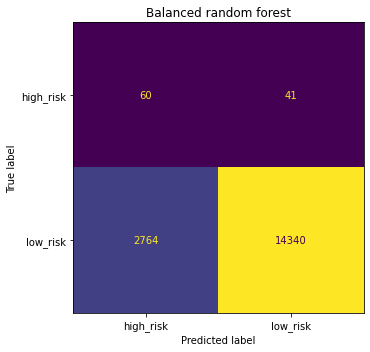

In [14]:
# Display the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

fig, axs = plt.subplots(figsize=(10, 5))
plot_confusion_matrix(brf, X_test, y_test, ax=axs, colorbar=False)
axs.set_title("Balanced random forest")

fig.tight_layout()

In [15]:
# Print the imbalanced classification report
y_pred_rf = brf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred_rf))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.59      0.84      0.04      0.71      0.49       101
   low_risk       1.00      0.84      0.59      0.91      0.71      0.51     17104

avg / total       0.99      0.84      0.60      0.91      0.71      0.51     17205



In [24]:
# List the features sorted in descending order by feature importance
importances = brf.feature_importances_

sorted_indices = np.argsort(importances)[::-1]
imp_features = X_train.columns[sorted_indices]
print(f'5 most important features: {imp_features[:5]}')
print(f'5 most important feature scores: {importances[:5]}')

5 most important features: Index(['total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt', 'total_pymnt',
       'total_pymnt_inv'],
      dtype='object')
5 most important feature scores: [0.01272429 0.03545976 0.0170144  0.01696756 0.01933303]


Easy Ensemble Classifier### Easy Ensemble Classifier

In [17]:
# Train the Classifier
from imblearn.ensemble import EasyEnsembleClassifier

eec = EasyEnsembleClassifier(random_state=42)
eec.fit(X_train, y_train)

EasyEnsembleClassifier(random_state=42)

In [18]:
# Calculated the balanced accuracy score
y_pred_eec = eec.predict(X_test)
print("Balanced Random Forest classifier performance:")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_eec):.2f} ")

Balanced Random Forest classifier performance:
Balanced accuracy: 0.74 


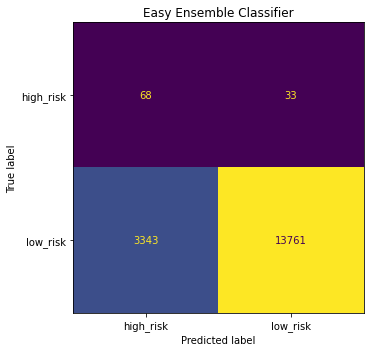

In [19]:
# Display the confusion matrix
fig, axs = plt.subplots(figsize=(10, 5))
plot_confusion_matrix(eec, X_test, y_test, ax=axs, colorbar=False)
axs.set_title("Easy Ensemble Classifier")

fig.tight_layout()

In [20]:
# Print the imbalanced classification report
y_pred_eec = eec.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred_eec))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.67      0.80      0.04      0.74      0.53       101
   low_risk       1.00      0.80      0.67      0.89      0.74      0.55     17104

avg / total       0.99      0.80      0.67      0.89      0.74      0.55     17205



### Final Questions

1. Which model had the best balanced accuracy score?

     Easy Ensemble Classifier has 0.74

2. Which model had the best recall score?

    Balanced Random Forest Classifier

3. Which model had the best geometric mean score?

    Easy Ensemble Classifier has 0.74

4. What are the top three features?

    'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt'